# IMDB
Case study with Recurrent Neural Network to demonstrate usage of TensorFlow 2.0 (Keras).

[ https://www.tensorflow.org/tutorials/keras/basic_text_classification ]

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from time import localtime, strftime
import tensorflow as tf
from tensorflow.keras.datasets import imdb

tf.__version__

'2.0.0-alpha0'

## Preprocessing
Loading and exploring data, and padding in preparation as input to a model.

(Note: Code in lines 1 and 5 below is there only to allow correct loading of the imdb dataset. Value for parameter `allow_pickle` must be set temporarily to `true`, but only temporarily since otherwise this would allow for the Python-equivalent of an SQL injection attack in a pickle file.
See

[ https://stackoverflow.com/a/57391693 ]

[ https://stackoverflow.com/a/56062555 ]

In [55]:
np.load.__defaults__=(None, True, True, 'ASCII')

number_of_words = 20000
(X_train,y_train), (X_test,y_test) = imdb.load_data( num_words=number_of_words )
print( "X_train: {}".format(X_train.shape) )
print( "X_test:  {}".format(X_train.shape) )

np.load.__defaults__=(None, False, True, 'ASCII')

X_train: (25000,)
X_test:  (25000,)


In [56]:
#explore train and test dataset
print( "Lengths of first and second reviews in X_train: {},{}".format( len(X_train[0]), len(X_train[1]) ) )
print( "X_train[0]: {}".format( X_train[0] ) )

#Convert integers back to words using helper functions from TensorFlow tutorial
#dictionary mapping words to an integer index
word_index = imdb.get_word_index()

#the first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print( "X_train[0]: {}...".format( decode_review( X_train[0][:14] ) ) )
print( "y_train[0]: {}".format( "positive" if (y_train[0]==1) else "negative" ) )

print( "X_test[0]: {}...".format( decode_review( X_test[0][:19] ) ) )
print( "y_test[0]: {}".format( "positive" if (y_test[0]==1) else "negative" ) )

#decode_review( X_test[0] )

Lengths of first and second reviews in X_train: 218,189
X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16,

In [57]:
#padding
max_len = 100
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)
print( "X_train[0]: {}".format( X_train[0] ) )
print( "X_train[0]: {}...".format( decode_review( X_train[0][:14] ) ) )

X_train[0]: [ 1415    33     6    22    12   215    28    77    52     5    14   407
    16    82 10311     8     4   107   117  5952    15   256     4     2
     7  3766     5   723    36    71    43   530   476    26   400   317
    46     7     4 12118  1029    13   104    88     4   381    15   297
    98    32  2071    56    26   141     6   194  7486    18     4   226
    22    21   134   476    26   480     5   144    30  5535    18    51
    36    28   224    92    25   104     4   226    65    16    38  1334
    88    12    16   283     5    16  4472   113   103    32    15    16
  5345    19   178    32]
X_train[0]: cry at a film it must have been good and this definitely was also...


## Model Construction
Recurrent neural network.

### Architecture and Optimization Strategy
Sequential network with size-3 kernels and max pooling. Learning will use Adam optimizer, with sparse categorical cross entropy as loss and sparse categorical accuracy as performance metric.

[ https://stackoverflow.com/questions/44477489/keras-difference-between-categorical-accuracy-and-sparse-categorical-accuracy ]

In [49]:
#---[ Architecture ]------------------------------------------------------
#network type: a sequence of layers
model = tf.keras.models.Sequential()

#layer 1: embedding of size 128
model.add( tf.keras.layers.Embedding(input_dim=number_of_words, output_dim=128, input_shape=(X_train.shape[1],)) )

#layer 2: LSTM with hyperbolic tangent as activation
model.add( tf.keras.layers.LSTM(units=128, activation='tanh') )

#output layer: one unit with sigmoid as activation
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid') )


#---[ Optimization Strategy ]------------------------------------------------------
##validation set

##initial_learning_rate = ...
##
##lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
##    initial_learning_rate,
##    decay_steps=...,
##    decay_rate=...,
##    staircase=...)
##
##Adamdecay = tf.keras.optimizers.Adam(learning_rate=lr_schedule)*/
##model.compile( optimizer=Adamdecay, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'] )

model.compile( optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'] )


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


### Training
Three epochs in batch mode.

In [58]:
#validation set
X_val = X_train[-5000:]
y_val = y_train[-5000:]
X_train = X_train[:-5000]
y_train = y_train[:-5000]


tensorboard_cbk = tf.keras.callbacks.TensorBoard(
  log_dir='./imdb_tb/' + strftime( "%Y%b%dT%Hh%M", localtime() ).lower() + '/',
  histogram_freq=1,  # How often to log histogram visualizations
  embeddings_freq=1,  # How often to log embedding visualizations
  update_freq='epoch' # How often to write logs (default: once per epoch)
)

numepochs = 3
batchsize = 128
history = model.fit( X_train, y_train,
                     epochs=numepochs,
                     batch_size=batchsize,
                     validation_data=(X_val,y_val))#,
                     #callbacks=[tensorboard_cbk] )

W0814 17:53:14.172904 140030050273088 callbacks.py:1194] Embeddings will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.


Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.1037 - accuracy: 0.9631 - val_loss: 0.1419 - val_accuracy: 0.9470
Epoch 2/3
20000/20000 [==============================] - 26s 1ms/sample - loss: 0.0848 - accuracy: 0.9715 - val_loss: 0.1377 - val_accuracy: 0.9496
Epoch 3/3
20000/20000 [==============================] - 26s 1ms/sample - loss: 0.0674 - accuracy: 0.9765 - val_loss: 0.1636 - val_accuracy: 0.9384


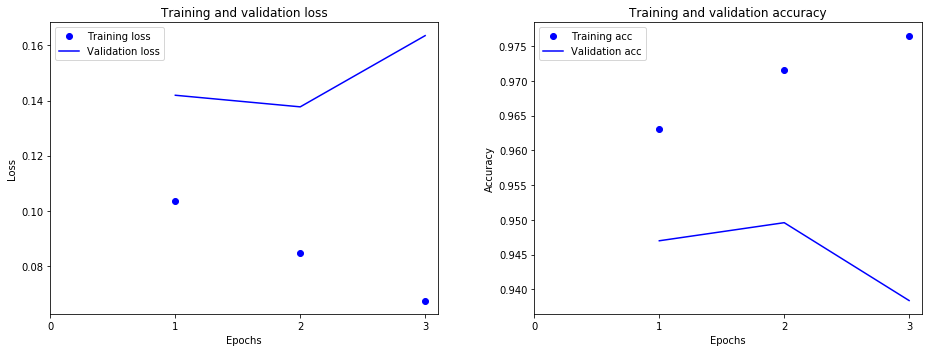

In [63]:
history_dict = history.history
#print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(epochs, loss, 'bo', label='Training loss')
axes[0].plot(epochs, val_loss, 'b-', label='Validation loss')
axes[0].set_xticks([i for i in range(0,len(epochs)+1)])
#axes[0].xaxis.set_major_locator(plt.MultipleLocator(5))
axes[0].legend()

axes[1].set_title('Training and validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(epochs, acc, 'bo', label='Training acc')
axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
axes[1].set_xticks([i for i in range(0,len(epochs)+1)])
#axes[1].xaxis.set_major_locator(plt.MultipleLocator(5))
axes[1].legend()

fig.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

## Evaluation and Prediction
Finally, the (approximated) model is evaluated using the test dataset.

In [64]:
test_loss, test_accuracy = model.evaluate( X_test, y_test )

print( "Test accuracy: {}".format(test_accuracy) )

25000/25000 [==============================] - 14s 577us/sample - loss: 0.5801 - accuracy: 0.8218
Test accuracy: 0.8218399882316589


### If all went well...
...save the model.

In [ ]:
#save architecture
model_json = model.to_json()
with open("imdb_model.json","w") as jsonfile:
    jsonfile.write(model_json)

#save weights
model.save_weights("imdb_model.h5")